In [52]:
import os

import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 80)

#行数
pd.set_option("display.max_rows", 101)

In [2]:
def load_df(csv_path='input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path,
                              converters={column: json.loads for column in JSON_COLUMNS}, 
                              dtype={'fullVisitorId': 'str'}, # Important!!
                              nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    return df

In [11]:
train_data_path = 'input/train.csv'
df_train = load_df(train_data_path)
df_train.head()

Loaded train.csv. Shape: (903653, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [4]:
df_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [9]:
print(df_train.isnull().any())

channelGrouping                                      False
date                                                 False
fullVisitorId                                        False
sessionId                                            False
socialEngagementType                                 False
visitId                                              False
visitNumber                                          False
visitStartTime                                       False
device.browser                                       False
device.browserSize                                   False
device.browserVersion                                False
device.deviceCategory                                False
device.flashVersion                                  False
device.isMobile                                      False
device.language                                      False
device.mobileDeviceBranding                          False
device.mobileDeviceInfo                              Fal

In [12]:
cols_to_drop = [col for col in df_train.columns if df_train[col].nunique() == 1]
df_train.drop(cols_to_drop, axis=1, inplace=True)
print("Dropped {0} columns.".format(len(cols_to_drop)))
print(cols_to_drop)

Dropped 24 columns.
['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.bounces', 'totals.newVisits', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode', 'trafficSource.isTrueDirect']


In [14]:
print(len(df_train.columns))
print(df_train.columns)

31
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')


In [16]:
# converting columns into more reasonable format
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    df_train[col] = df_train[col].astype(float)

In [19]:
for col in df_train.columns:
    if df_train[col].isnull().sum() > 0:
        rate = df_train[col].isnull().sum() * 100 / df_train.shape[0]
        print('Column {} has {:.4f}% missing values.'.format(col, rate))
    if df_train[col].dtype == 'object':
        if (df_train[col] == 'not available in demo dataset').sum() > 0:
            rate = (df_train[col] == 'not available in demo dataset').sum() * 100 / df_train.shape[0]
            print('Column {} has {:.4f}% values not available in dataset.'.format(col, rate))

Column geoNetwork.city has 56.2416% values not available in dataset.
Column geoNetwork.metro has 56.2416% values not available in dataset.
Column geoNetwork.region has 56.2416% values not available in dataset.
Column totals.pageviews has 0.0111% missing values.
Column totals.transactionRevenue has 98.7257% missing values.
Column trafficSource.adContent has 98.7887% missing values.
Column trafficSource.adwordsClickInfo.adNetworkType has 97.6252% missing values.
Column trafficSource.adwordsClickInfo.gclId has 97.6140% missing values.
Column trafficSource.adwordsClickInfo.page has 97.6252% missing values.
Column trafficSource.adwordsClickInfo.slot has 97.6252% missing values.
Column trafficSource.keyword has 55.6551% missing values.
Column trafficSource.referralPath has 63.3774% missing values.


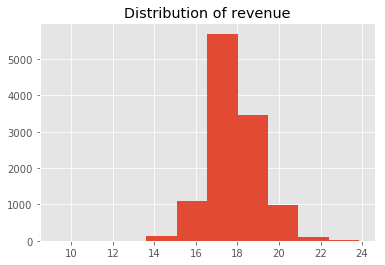

In [21]:
plt.hist(np.log1p(df_train.loc[df_train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

714167


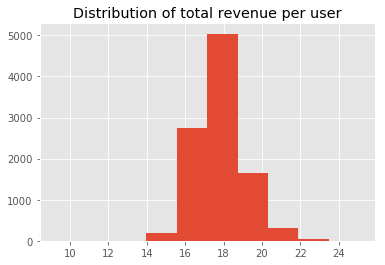

In [22]:
grouped = df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
print(len(grouped))
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

In [24]:
counts = df_train.loc[df_train['totals.transactionRevenue'] > 0, 'fullVisitorId'].value_counts()
print('There are {0} paying users ({1} total) in train data.'.format(len(counts), df_train['fullVisitorId'].nunique()))
print('{0} users ({1:.4f}% of paying) have 1 paid transaction.'.format(np.sum(counts == 1), 100 * np.sum(counts == 1) / len(counts)))
print('{0} users ({1:.4f}% of paying) have 2 paid transaction.'.format(np.sum(counts == 2), 100 * np.sum(counts == 2) / len(counts)))
print('')
print('Count of non-zero transactions per user:')
counts.head(10)

There are 9996 paying users (714167 total) in train data.
9029 users (90.3261% of paying) have 1 paid transaction.
714 users (7.1429% of paying) have 2 paid transaction.

Count of non-zero transactions per user:


7813149961404844386    33
1957458976293878100    16
4984366501121503466    16
6760732402251466726    15
2402527199731150932    15
0608915197735218105    13
7311242886083854158    12
8197879643797712877    10
9089132392240687728    10
7463172420271311409     9
Name: fullVisitorId, dtype: int64

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


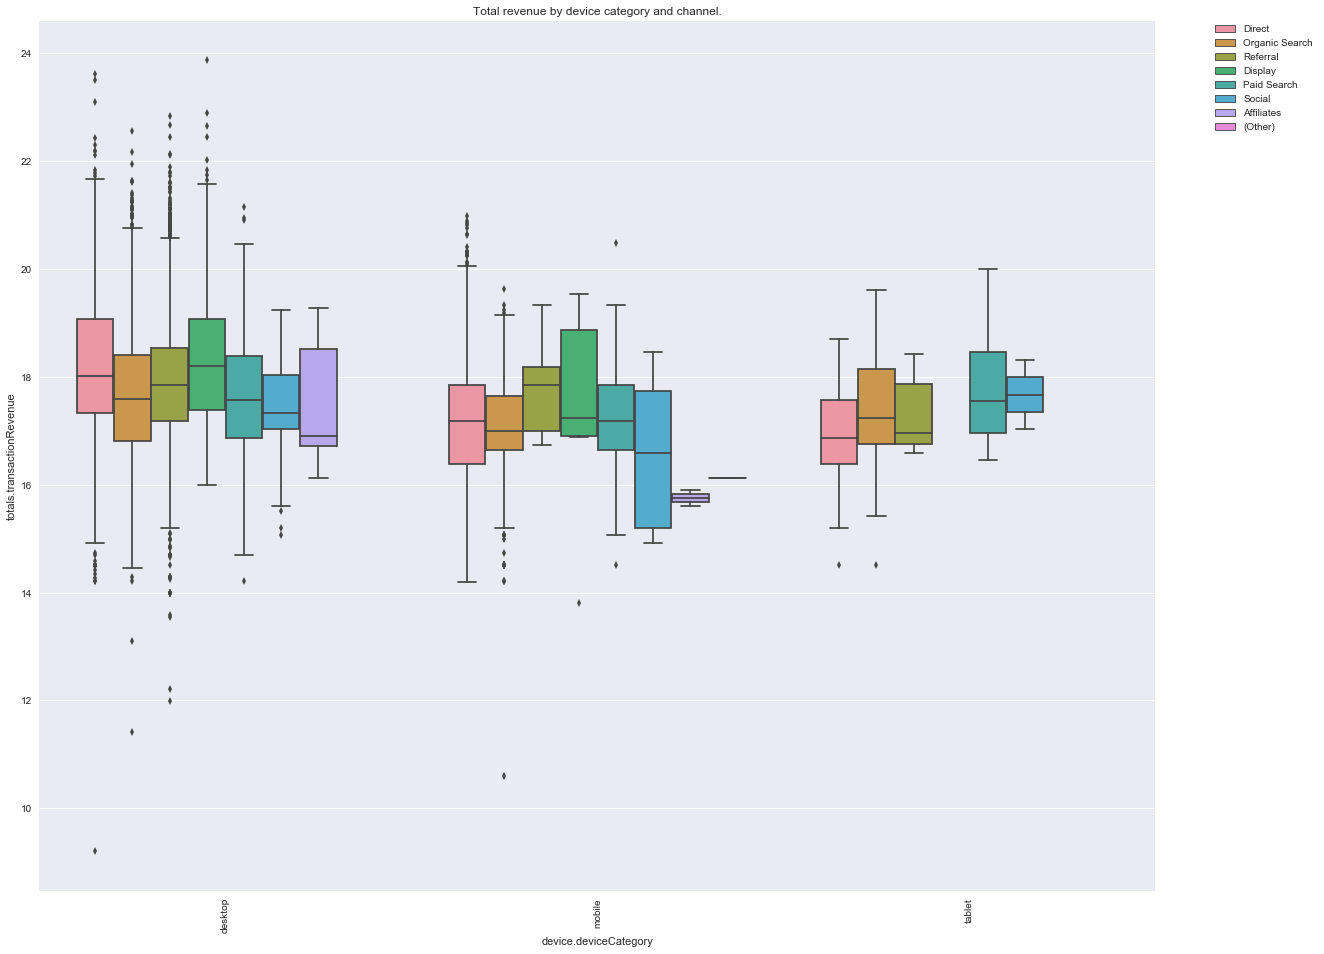

In [26]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].fillna(0)
df_train['totals.transactionRevenue'] = np.log1p(df_train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(20, 16)})
train_ = df_train.loc[df_train['totals.transactionRevenue'] > 0.0]
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train_)
plt.title("Total revenue by device category and channel.");
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [28]:
df_train['date'] = pd.to_datetime(df_train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
#test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

In [37]:
train_['totals.transactionRevenue'].min(), df_train.shape, train_.shape

(9.210440366976517, (903653, 31), (11515, 31))

In [36]:
train_.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

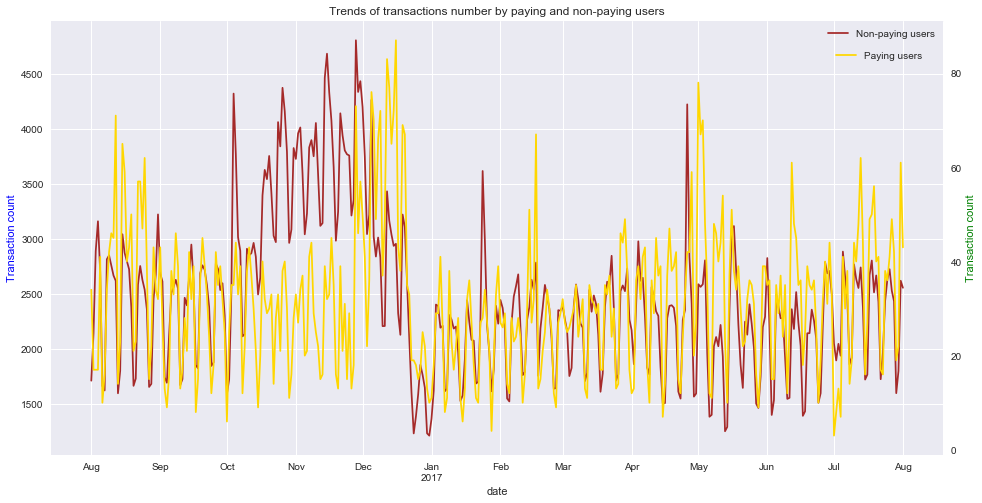

In [38]:
train_ = df_train.loc[df_train['totals.transactionRevenue'] > 0]
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of transactions number by paying and non-paying users");
df_train.groupby(['date'])['totals.transactionRevenue'].count().plot(color='brown')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Non-paying users'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='gold')
ax2.set_ylabel('Transaction count', color='g')
plt.legend(['Paying users'], loc=(0.875, 0.9))
plt.grid(False)

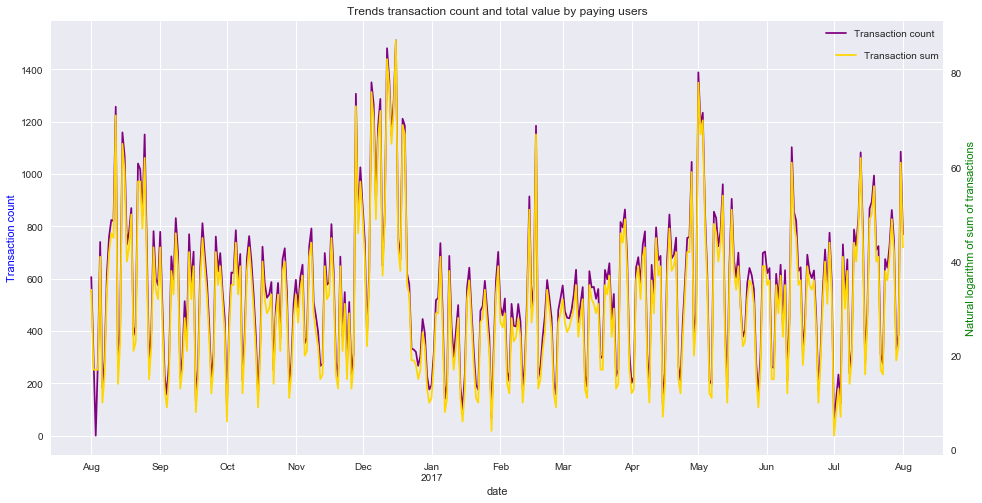

In [39]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends transaction count and total value by paying users")
df_train.groupby(['date'])['totals.transactionRevenue'].sum().plot(color='purple')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Transaction count'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='gold')
ax2.set_ylabel('Natural logarithm of sum of transactions', color='g')
plt.legend(['Transaction sum'], loc=(0.875, 0.9))
plt.grid(False)

Mean revenue per transaction


/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ValueError: Invalid RGBA argument: 0.2980392156862745

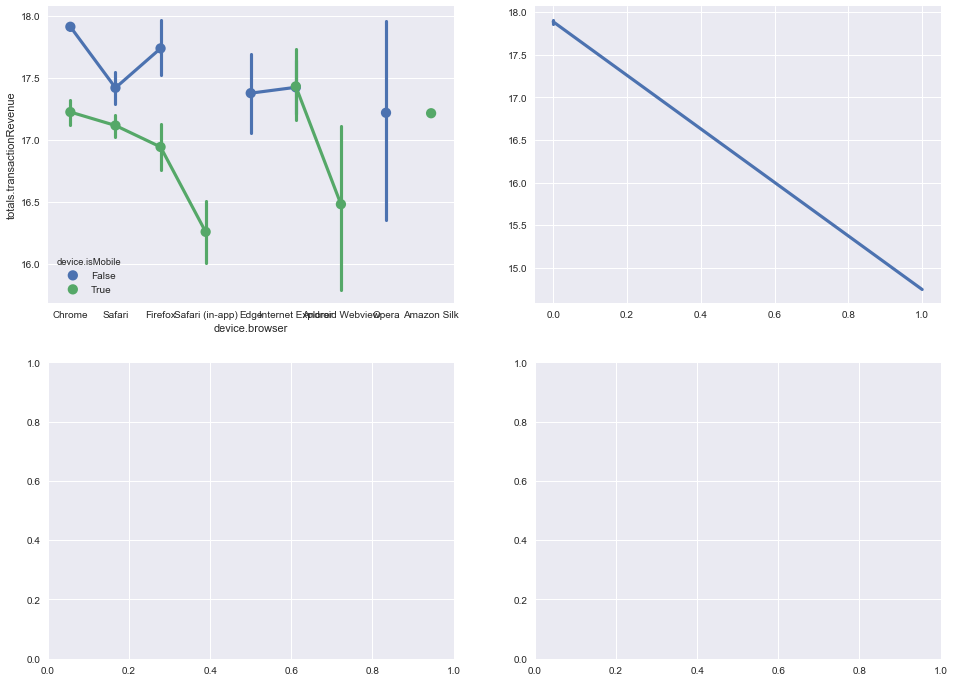

In [40]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
print('Mean revenue per transaction')
sns.pointplot(x="device.browser", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[0, 0])
sns.pointplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[0, 1])
sns.pointplot(x="device.operatingSystem", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[1, 0])
sns.pointplot(x="device.isMobile", y="totals.transactionRevenue", data=train_, ax = ax[1, 1])
plt.xticks(rotation=30)

In [41]:
df_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [42]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google


In [50]:
df_train_sort = df_train.sort_values(by=['fullVisitorId'])
df_train_sort.sample(50)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
892720,Referral,2017-03-24,4288267796231105352,4288267796231105352_1490385373,1490385373,1.0,1490385373,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/intl/en/permissions/using-the-logo.html,google.com
302732,Organic Search,2017-07-23,5540942375805083880,5540942375805083880_1500800612,1500800612,1.0,1500800612,Safari,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
544405,Social,2016-08-17,5907801362903401294,5907801362903401294_1471489056,1471489056,1.0,1471489056,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/en-GB/,youtube.com
803796,Direct,2017-04-01,1511994302874206797,1511994302874206797_1491031811,1491031811,1.0,1491031811,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),NaN,(direct)
707116,Direct,2016-08-04,3796617450085679380,3796617450085679380_1470365822,1470365822,1.0,1470365822,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),NaN,(direct)
115427,Referral,2016-08-24,3584936396842125279,3584936396842125279_1472051121,1472051121,6.0,1472051121,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/,mall.googleplex.com
297721,Social,2016-12-02,8836528173020053566,8836528173020053566_1480748377,1480748377,1.0,1480748377,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/,youtube.com
709899,Direct,2016-08-04,6876569189555148000,6876569189555148000_1470347806,1470347806,1.0,1470347806,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),NaN,(direct)
509305,Organic Search,2017-02-23,4392075072675440320,4392075072675440320_1487882917,1487882917,1.0,1487882917,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
123676,Social,2016-08-05,2598948311672152467,2598948311672152467_1470434066,1470434066,1.0,1470434066,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/ru/,youtube.com


In [59]:
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 100)

df_sample = df_train_sort[df_train_sort['fullVisitorId'] == '6588500311054802771'].sort_values(by=['fullVisitorId','visitNumber'])
df_sample

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
458254,Organic Search,2016-09-22,6588500311054802771,6588500311054802771_1474612131,1474612131,1.0,1474612131,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,18.0,16.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
741822,Organic Search,2016-09-26,6588500311054802771,6588500311054802771_1474875964,1474875964,2.0,1474875964,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
740344,Organic Search,2016-09-26,6588500311054802771,6588500311054802771_1474879233,1474879233,3.0,1474879233,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,9.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
742030,Organic Search,2016-09-26,6588500311054802771,6588500311054802771_1474915166,1474915166,4.0,1474915166,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
370663,Organic Search,2016-09-27,6588500311054802771,6588500311054802771_1474982746,1474982746,5.0,1474982746,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Europe,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
370680,Organic Search,2016-09-27,6588500311054802771,6588500311054802771_1474986699,1474986699,6.0,1474986699,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Europe,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
645508,Affiliates,2016-10-06,6588500311054802771,6588500311054802771_1475740099,1475740099,7.0,1475740099,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,Data Share Promo,NaN,affiliate,NaN,Partners
646071,Affiliates,2016-10-06,6588500311054802771,6588500311054802771_1475742761,1475742761,8.0,1475742761,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,Data Share Promo,NaN,affiliate,NaN,Partners
644577,Affiliates,2016-10-06,6588500311054802771,6588500311054802771_1475745261,1475745261,9.0,1475745261,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,13.0,11.0,0.0,NaN,NaN,NaN,NaN,NaN,Data Share Promo,NaN,affiliate,NaN,Partners
646105,Affiliates,2016-10-06,6588500311054802771,6588500311054802771_1475748112,1475748112,10.0,1475748112,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available

In [60]:
df_sample['lag1_totals.hits'] = df_sample['totals.hits'].shift(1)
df_sample.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,lag1_totals.hits
458254,Organic Search,2016-09-22,6588500311054802771,6588500311054802771_1474612131,1474612131,1.0,1474612131,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,18.0,16.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,NaN
741822,Organic Search,2016-09-26,6588500311054802771,6588500311054802771_1474875964,1474875964,2.0,1474875964,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,18.0
740344,Organic Search,2016-09-26,6588500311054802771,6588500311054802771_1474879233,1474879233,3.0,1474879233,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,9.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,1.0
742030,Organic Search,2016-09-26,6588500311054802771,6588500311054802771_1474915166,1474915166,4.0,1474915166,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,ziggo.nl,not available in demo dataset,Western Europe,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,9.0
370663,Organic Search,2016-09-27,6588500311054802771,6588500311054802771_1474982746,1474982746,5.0,1474982746,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,Netherlands,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Europe,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,2.0
